In [94]:
from HeaderP import *

In [95]:
prot = pd.read_csv('KeplerRot-LAMOST.csv')

In [96]:
prot = prot.loc[prot['Teff_lam']>0].reset_index(drop=True)
prot = prot.loc[prot['logg_lam']>4].reset_index(drop=True)
prot = prot.loc[prot['Teff_lam']<9000].reset_index(drop=True)
print(np.shape(prot))

(9499, 22)


In [97]:
rvars = pd.read_pickle('Mc_Gar_Sant_no_visual_binaries.pkl')
prot = pd.merge(prot, rvars, left_on='KIC', right_on='kepid', how='inner')
prot = pd.merge(prot, pd.read_csv('CSVs/LG_Rvar_Kepler.csv')[['KIDs','Rvar']], 
                left_on='KIC', right_on='KIDs', how='inner')

In [98]:
prot = prot.drop_duplicates('KIC',keep='first')
print(np.shape(prot))

(8144, 205)


(7500.0, 4000.0)

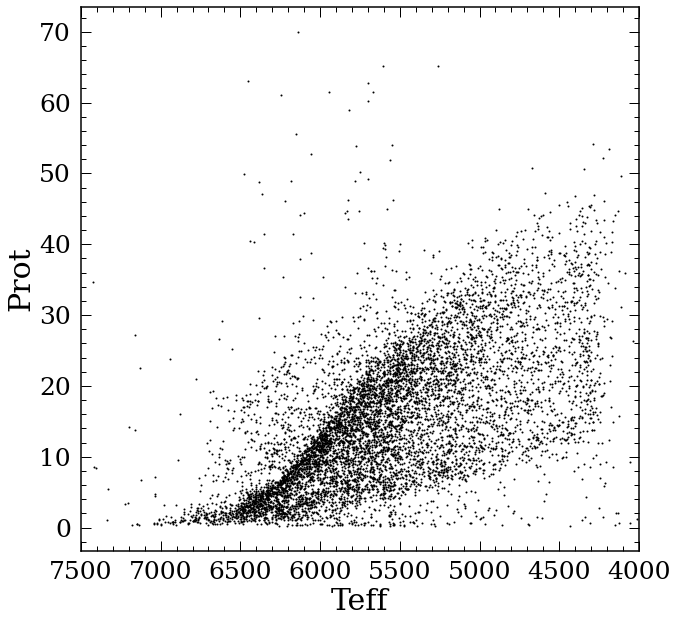

In [99]:
plt.scatter(prot['Teff_lam'],prot['Prot_x'],s=1,c='k')
plt.xlabel('Teff')
plt.ylabel('Prot')
plt.xlim([7500,4000])

In [101]:
list(prot.columns)

['DR2Name',
 'KIC',
 'RA',
 'Dec',
 'Gmag',
 'BP_RP',
 'parallax_x',
 'pmra_x',
 'pmde',
 'rv_gaia',
 'erv_gaia',
 'Prot_x',
 'RV_lam',
 'e_RV_lam',
 'Teff_lam',
 'e_Teff_lam',
 'logg_lam',
 'e_logg_lam',
 'feh_lam',
 'e_feh_lam',
 'afe_lam',
 'e_afe_lam',
 'CP/CB_candidate_flag',
 'DC',
 'E_M',
 'E_Teff',
 'E_logg',
 'FQ',
 'Flag',
 'FliPer_Class',
 'GAIA_inary_flag',
 'GAIA_subgiant_flag',
 'IQ',
 'KID',
 'KOI_flag',
 'Kp',
 'LPH',
 'M',
 'Mass',
 'Prot_y',
 'Prot_err',
 'Rper',
 'Source',
 'Teff',
 'Tidally_synchronized_binaries',
 'Type',
 '_DE',
 '_RA',
 'a_g_percentile_lower',
 'a_g_percentile_upper',
 'a_g_val',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_gof_al',
 'astrometric_matched_observations',
 'astrometric_n_bad_obs_al',
 'astrometric_n_good_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_obs_al',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_e

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

prot = prot.dropna(subset=['Teff_lam', 'e_Teff_lam', 'Rper', 'BP_RP', 'parallax_x', 'v_tan','Prot_x','Prot_err','phot_g_mean_flux','logg_lam']).reset_index(drop=True)
X = prot[['Teff_lam', 'e_Teff_lam', 'Rper', 'BP_RP', 'parallax_x', 'v_tan','logg_lam','phot_g_mean_flux']].dropna().values
y = prot[['Prot_x']].values
y_err = prot[['Prot_err']].values

Ntrain = int(0.8*len(y))
Ntest = len(y)-Ntrain
# Choose stars at random and split.
shuffle_inds = np.arange(len(y))

prot_pred = np.zeros(len(y))
regr = RandomForestRegressor(n_estimators=100)
for i in range(5):
    train_inds = np.append(shuffle_inds[:i*Ntest],shuffle_inds[(i+1)*Ntest:])
    test_inds = shuffle_inds[i*Ntest:(i+1)*Ntest]

    y_train, X_train = y[train_inds], X[train_inds, :]
    y_test, X_test = y[test_inds], X[test_inds, :]

    regr.fit(X_train, y_train)
    
    prot_pred[i*Ntest:(i+1)*Ntest]=regr.predict(X_test)

<ipython-input-102-8a0f2b5e673b>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
<ipython-input-102-8a0f2b5e673b>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
<ipython-input-102-8a0f2b5e673b>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
<ipython-input-102-8a0f2b5e673b>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
<ipython-input-102-8a0f2b5e673b>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

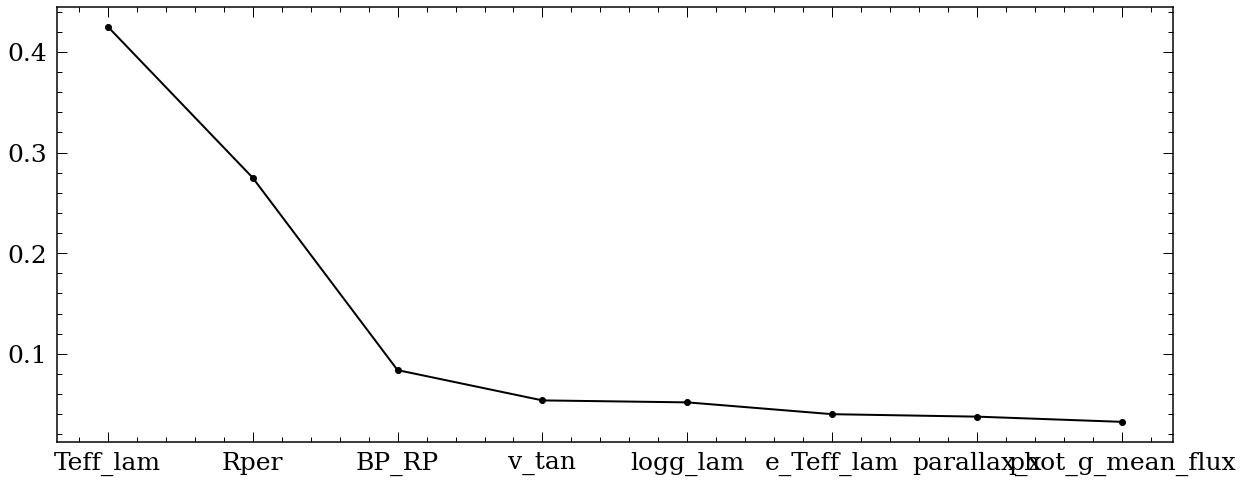

In [103]:
plt.figure(figsize=(20,8))
imp, fea = zip(*sorted(zip(regr.feature_importances_, ['Teff_lam', 'e_Teff_lam', 'Rper', 'BP_RP', 'parallax_x', 'v_tan','logg_lam','phot_g_mean_flux'])))

plt.plot(fea[::-1], imp[::-1],'ko-')


Text(0, 0.5, 'Predicted Prot [Days]')

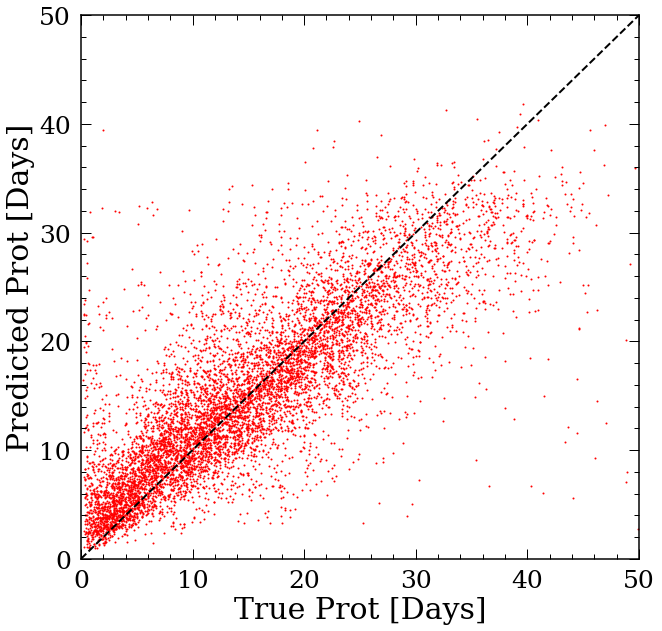

In [104]:
plt.figure()
plt.scatter(prot['Prot_x'],prot_pred,c='r',s=1)
plt.plot([0,60],[0,60],'k--')
plt.xlim([0,50])
plt.ylim([0,50])
plt.xlabel('True Prot [Days]')
plt.ylabel('Predicted Prot [Days]')


In [105]:
regr.fit(X, y)
prot['Prot_pred']=regr.predict(X)
    
    

<ipython-input-105-9b6b44ed8e06>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X, y)


Text(0, 0.5, 'Predicted Prot [Days]')

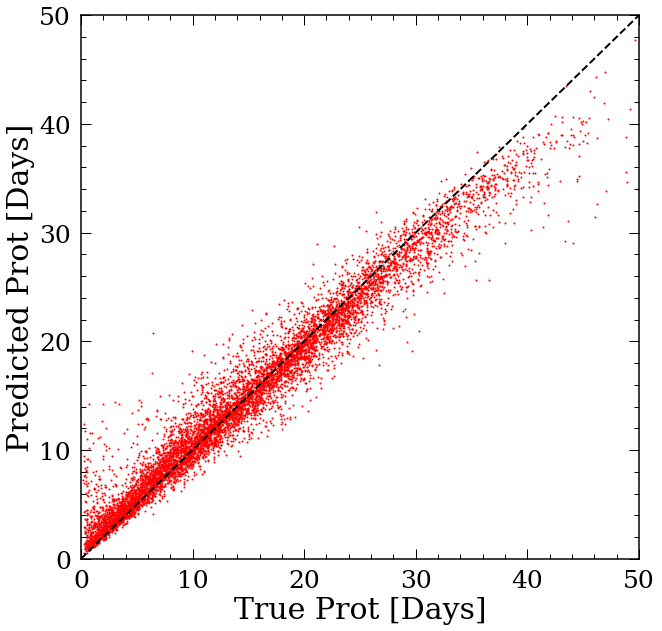

In [106]:
plt.figure()
plt.scatter(prot['Prot_x'],prot['Prot_pred'],c='r',s=1)
plt.plot([0,60],[0,60],'k--')
plt.xlim([0,50])
plt.ylim([0,50])
plt.xlabel('True Prot [Days]')
plt.ylabel('Predicted Prot [Days]')



In [107]:
prot['pred_diff']=(prot_pred-prot['Prot_x'])


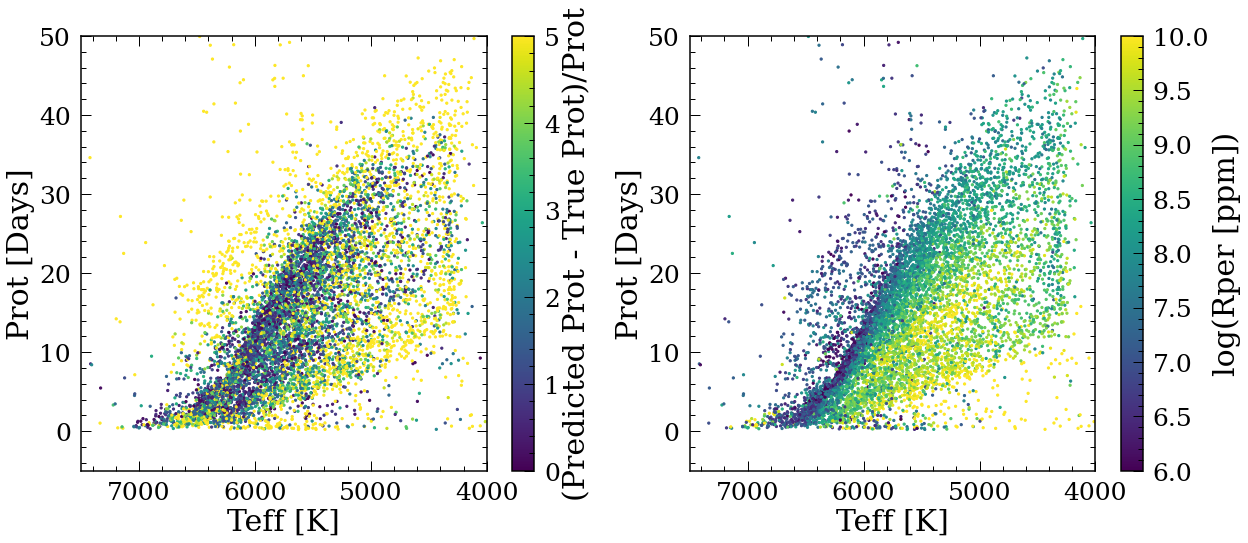

In [108]:
plt.figure(figsize=(20,8))
threas = 5
plt.subplot(1,2,1)
plt.scatter(prot['Teff_lam'],prot['Prot_x'],c=abs(prot['pred_diff']),s=5,vmin=0,vmax=threas)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('(Predicted Prot - True Prot)/Prot')

plt.subplot(1,2,2)
plt.scatter(prot['Teff_lam'],prot['Prot_x'],c=np.log(prot['Rper']),s=5,vmin=6,vmax=10)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('log(Rper [ppm])')

In [109]:
prot['planet']=(prot['planet?']!='none')


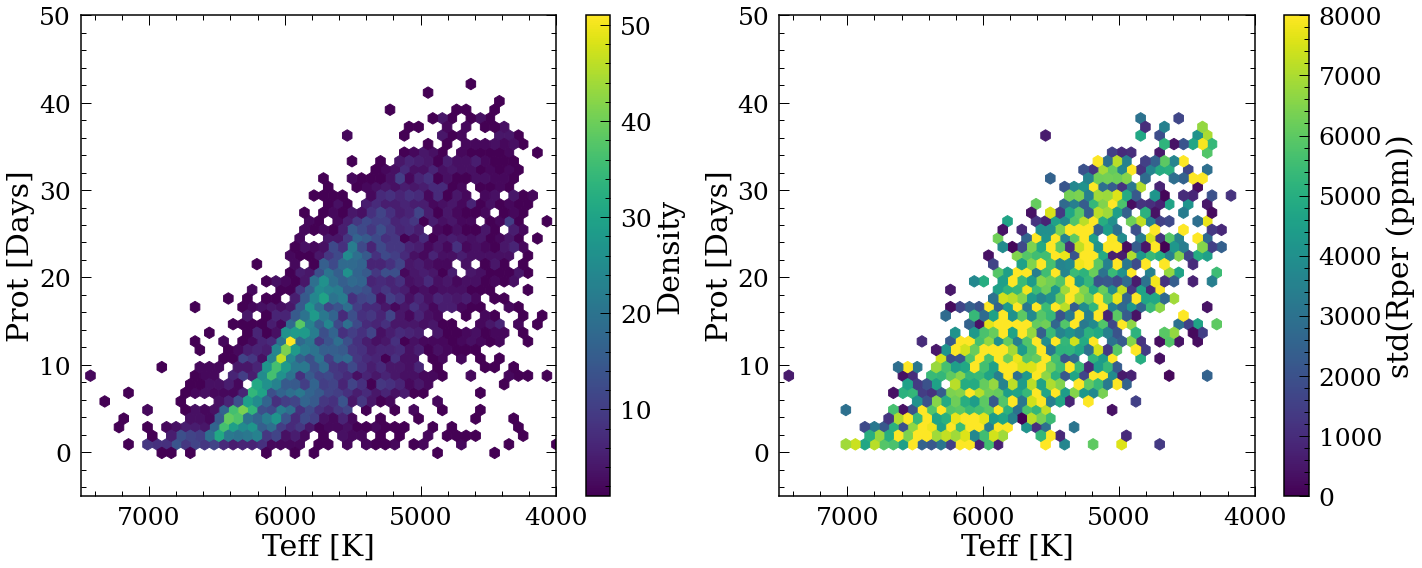

In [110]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
m=abs(prot['pred_diff'])<threas
goodpreid=prot[m]
plt.hexbin(prot['Teff_lam'][m],prot['Prot_x'][m], 
           extent=(4000,7500,-5,50), gridsize=50, mincnt=1)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('Density')


plt.subplot(1,2,2)
plt.hexbin(prot['Teff_lam'][m],prot['Prot_x'][m],C = prot['Rper'], vmin=0, vmax=8000,
           extent=(4000,7500,-5,50), gridsize=50, mincnt=1,reduce_C_function=np.std)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('std(Rper (ppm))')
plt.tight_layout()

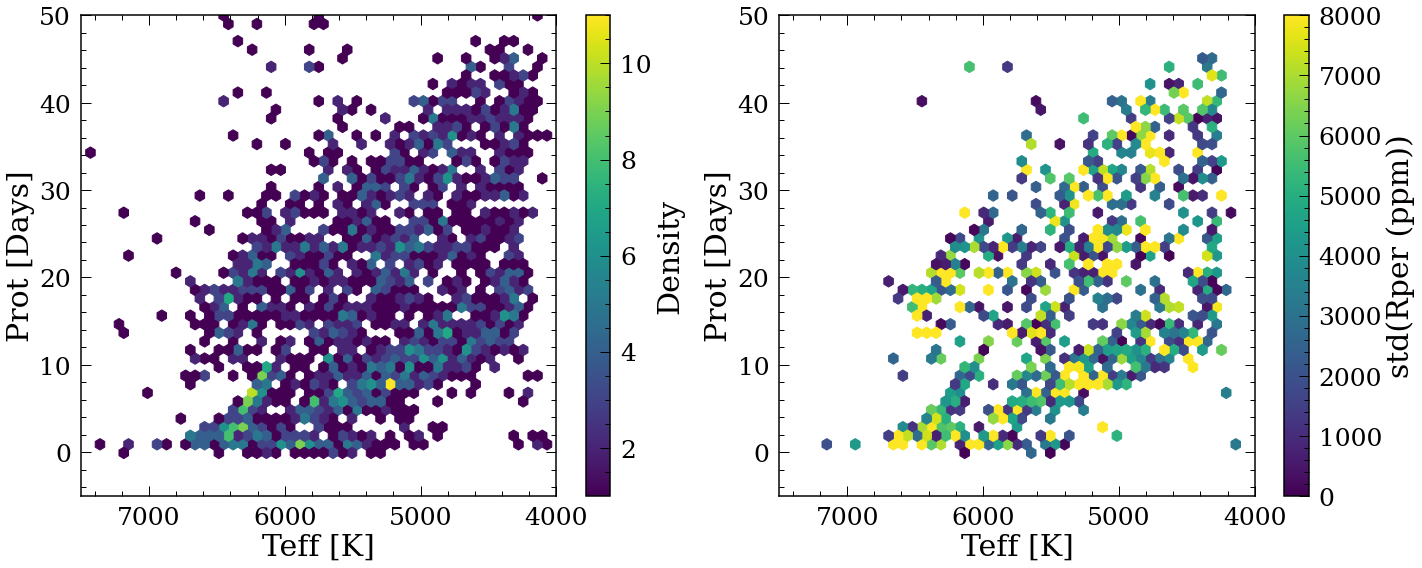

In [111]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
m2=abs(prot['pred_diff'])>threas
plt.hexbin(prot['Teff_lam'][m2],prot['Prot_x'][m2], 
           extent=(4000,7500,-5,50), gridsize=50, mincnt=1)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(prot['Teff_lam'][m2],prot['Prot_x'][m2],C = prot['Rper'], vmin=0, vmax=8000,
           extent=(4000,7500,-5,50), gridsize=50, mincnt=1,reduce_C_function=np.std)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('std(Rper (ppm))')
plt.tight_layout()

In [112]:
print(sum(prot['planet'][m])/sum(m))
print(sum(prot['planet'][m2])/sum(m2))

0.018842530282637954
0.022632794457274827


In [ ]:
for i in prot.columns:
    if (i == 'DR2Name') or (i == 'solution_id') or (i == 'planet?') or ('flag' in i) or (i == 'Flag') or (i=='datalink_url') or ('designation' in i) or (i=='epoch_photometry_url') or ('prov' in i):
        continue
    plt.figure()
    plt.hist(np.array(prot[i][m].dropna(),dtype=float),
             bins=np.linspace(min(prot[i]),max(prot[i]),100),color='k',alpha=0.5,density=True,label='Good')
    plt.hist(np.array(prot[i][m2].dropna(),dtype=float),
             bins=np.linspace(min(prot[i]),max(prot[i]),100),color='r',alpha=0.5,density=True,label='Bad')
    plt.title(i,fontsize=25)
    plt.legend()

No Rvar

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

prot = prot.dropna(subset=['Teff_lam', 'e_Teff_lam', 'BP_RP', 'parallax_x', 'v_tan','Prot_x','Prot_err','logg_lam','phot_g_mean_flux']).reset_index(drop=True)
X = prot[['Teff_lam', 'e_Teff_lam','BP_RP', 'parallax_x', 'v_tan','logg_lam','phot_g_mean_flux']].dropna().values
y = prot[['Prot_x']].values
y_err = prot[['Prot_err']].values

Ntrain = int(0.8*len(y))
Ntest = len(y)-Ntrain
# Choose stars at random and split.
shuffle_inds = np.arange(len(y))

prot_pred = np.zeros(len(y))
regr = RandomForestRegressor(n_estimators=100)
for i in range(5):
    train_inds = np.append(shuffle_inds[:i*Ntest],shuffle_inds[(i+1)*Ntest:])
    test_inds = shuffle_inds[i*Ntest:(i+1)*Ntest]

    y_train, X_train = y[train_inds], X[train_inds, :]
    y_test, X_test = y[test_inds], X[test_inds, :]

    regr.fit(X_train, y_train)
    
    prot_pred[i*Ntest:(i+1)*Ntest]=regr.predict(X_test)

<ipython-input-113-561b099b24ae>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
<ipython-input-113-561b099b24ae>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
<ipython-input-113-561b099b24ae>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
<ipython-input-113-561b099b24ae>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
<ipython-input-113-561b099b24ae>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

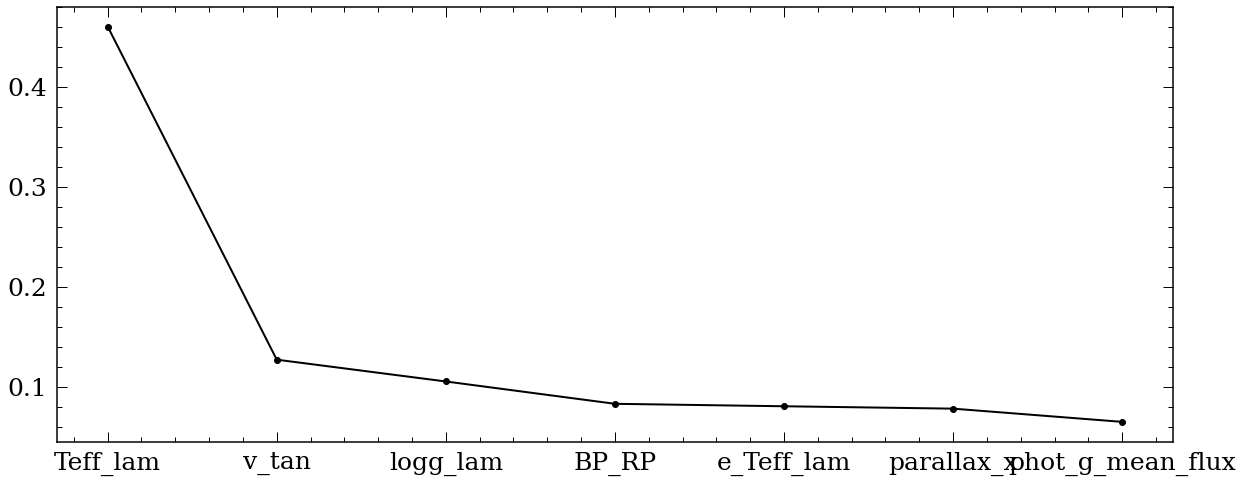

In [123]:
plt.figure(figsize=(20,8))
imp, fea = zip(*sorted(zip(regr.feature_importances_, ['Teff_lam', 'e_Teff_lam', 'BP_RP', 'parallax_x', 'v_tan','logg_lam','phot_g_mean_flux'])))

plt.plot(fea[::-1], imp[::-1],'ko-')



Text(0, 0.5, 'Predicted Prot [Days]')

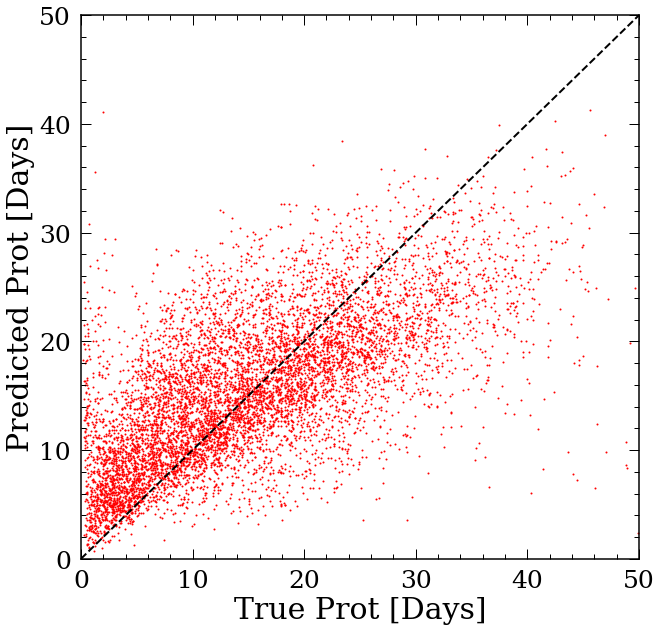

In [115]:
plt.figure()
plt.scatter(prot['Prot_x'],prot_pred,c='r',s=1)
plt.plot([0,60],[0,60],'k--')
plt.xlim([0,50])
plt.ylim([0,50])
plt.xlabel('True Prot [Days]')
plt.ylabel('Predicted Prot [Days]')



In [116]:
regr.fit(X, y)
prot['Prot_pred_woRvar']=regr.predict(X)
    
    

<ipython-input-116-e02b979ef716>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X, y)


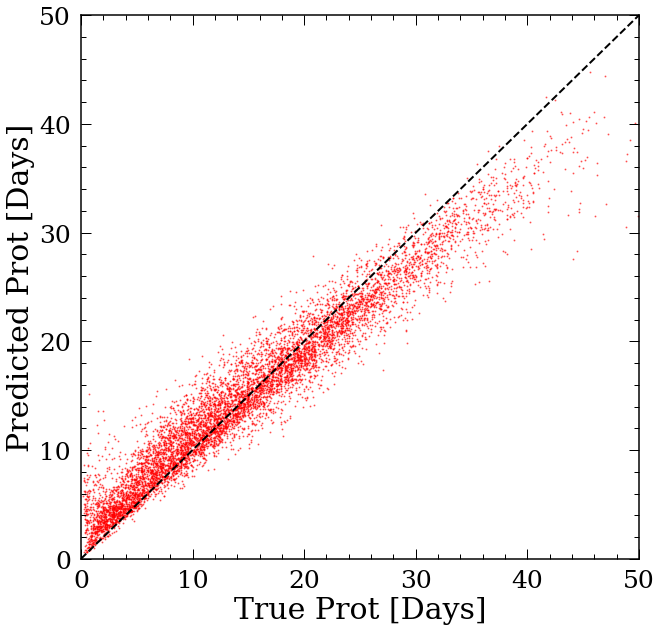

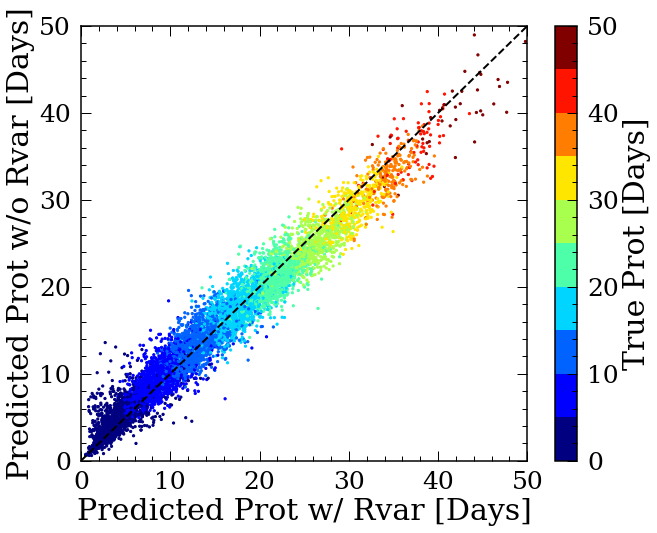

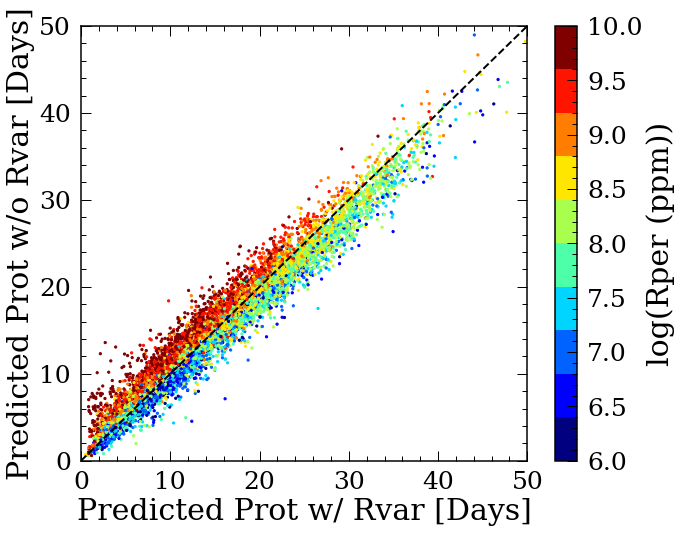

In [117]:
plt.figure()
plt.scatter(prot['Prot_x'],prot['Prot_pred_woRvar'],c='r',s=1,alpha=0.5)
plt.plot([0,60],[0,60],'k--')
plt.xlim([0,50])
plt.ylim([0,50])
plt.xlabel('True Prot [Days]')
plt.ylabel('Predicted Prot [Days]')


plt.figure(figsize=(10,8))
cmap = plt.cm.get_cmap('jet',10)
plt.scatter(prot['Prot_pred'],prot['Prot_pred_woRvar'],c=prot['Prot_x'],s=5, cmap=cmap, vmin=0, vmax=50)
plt.plot([0,60],[0,60],'k--')
plt.xlim([0,50])
plt.ylim([0,50])
plt.xlabel('Predicted Prot w/ Rvar [Days]')
plt.ylabel('Predicted Prot w/o Rvar [Days]')
cb = plt.colorbar()
cb.set_label('True Prot [Days]')

plt.figure(figsize=(10,8))
cmap = plt.cm.get_cmap('jet',10)
plt.scatter(prot['Prot_pred'],prot['Prot_pred_woRvar'],c=np.log(prot['Rper']),s=5, cmap=cmap, vmin=6, vmax=10)
plt.plot([0,60],[0,60],'k--')
plt.xlim([0,50])
plt.ylim([0,50])
plt.xlabel('Predicted Prot w/ Rvar [Days]')
plt.ylabel('Predicted Prot w/o Rvar [Days]')
cb = plt.colorbar()
cb.set_label('log(Rper (ppm))')

In [118]:
prot['pred_diff']=(prot_pred-prot['Prot_x'])



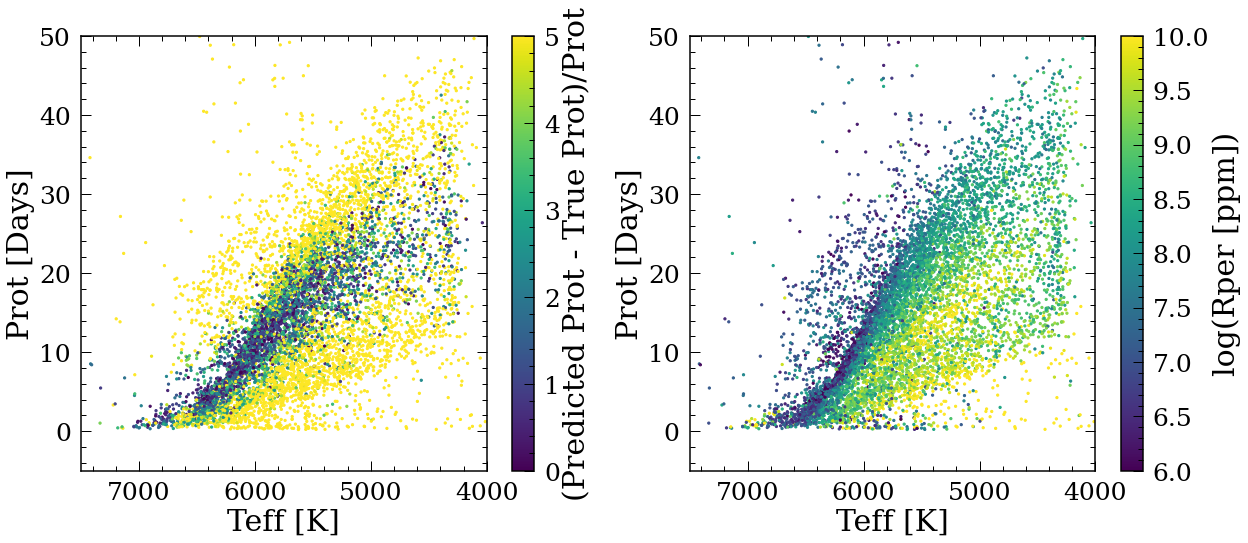

In [119]:
plt.figure(figsize=(20,8))
threas = 5
plt.subplot(1,2,1)
plt.scatter(prot['Teff_lam'],prot['Prot_x'],c=abs(prot['pred_diff']),s=5,vmin=0,vmax=threas)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('(Predicted Prot - True Prot)/Prot')

plt.subplot(1,2,2)
plt.scatter(prot['Teff_lam'],prot['Prot_x'],c=np.log(prot['Rper']),s=5,vmin=6,vmax=10)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('log(Rper [ppm])')

In [120]:
prot['planet']=(prot['planet?']!='none')



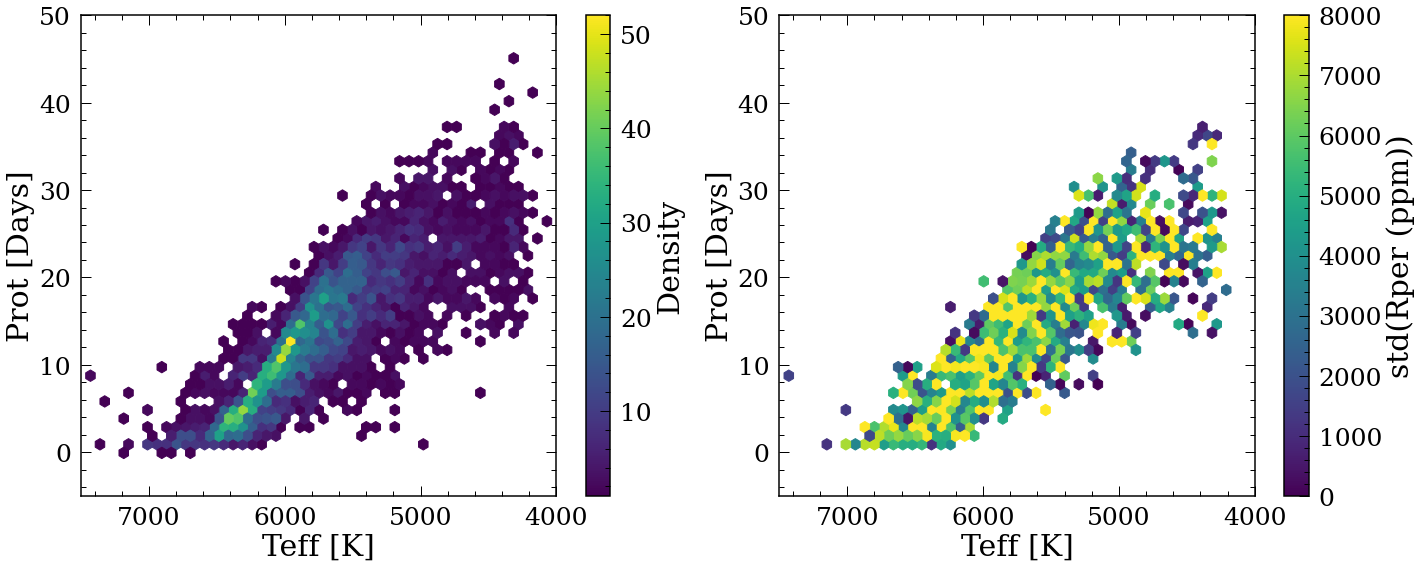

In [121]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
m=abs(prot['pred_diff'])<threas
goodpreid=prot[m]
plt.hexbin(prot['Teff_lam'][m],prot['Prot_x'][m], 
           extent=(4000,7500,-5,50), gridsize=50, mincnt=1)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('Density')


plt.subplot(1,2,2)
plt.hexbin(prot['Teff_lam'][m],prot['Prot_x'][m],C = prot['Rper'], vmin=0, vmax=8000,
           extent=(4000,7500,-5,50), gridsize=50, mincnt=1,reduce_C_function=np.std)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('std(Rper (ppm))')
plt.tight_layout()

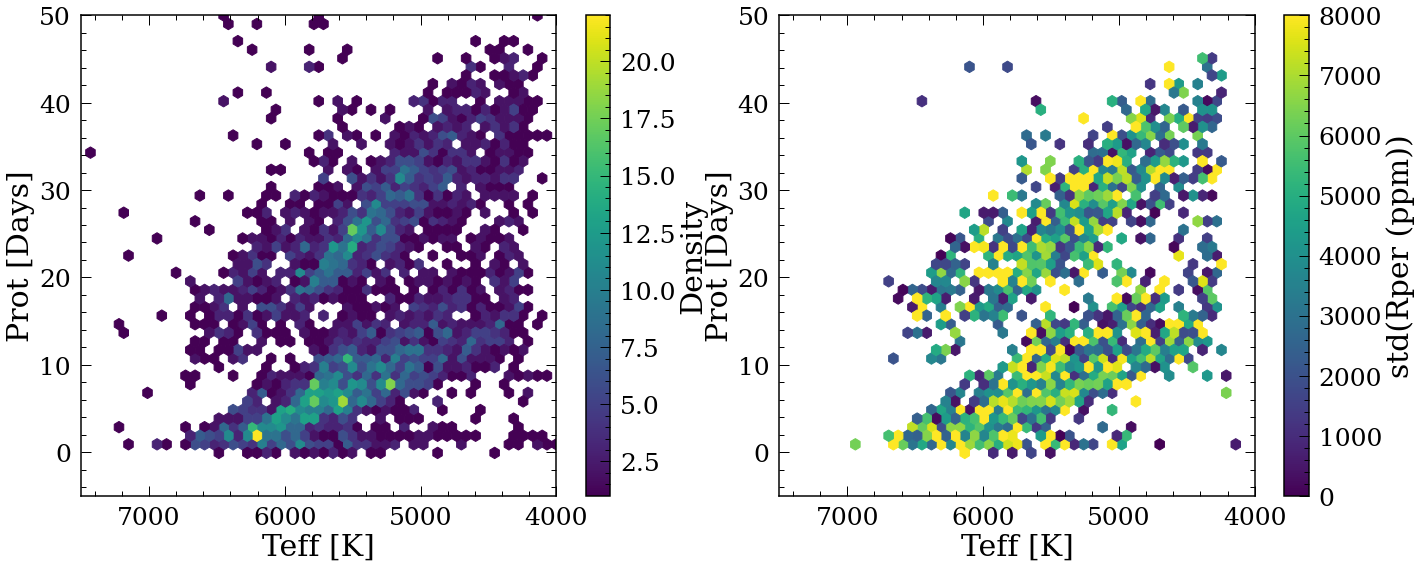

In [124]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
m2=abs(prot['pred_diff'])>threas
plt.hexbin(prot['Teff_lam'][m2],prot['Prot_x'][m2], 
           extent=(4000,7500,-5,50), gridsize=50, mincnt=1)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(prot['Teff_lam'][m2],prot['Prot_x'][m2],C = prot['Rper'], vmin=0, vmax=8000,
           extent=(4000,7500,-5,50), gridsize=50, mincnt=1,reduce_C_function=np.std)
plt.xlim([7500,4000])
plt.ylim([-5,50])
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
cb = plt.colorbar()
cb.set_label('std(Rper (ppm))')
plt.tight_layout()

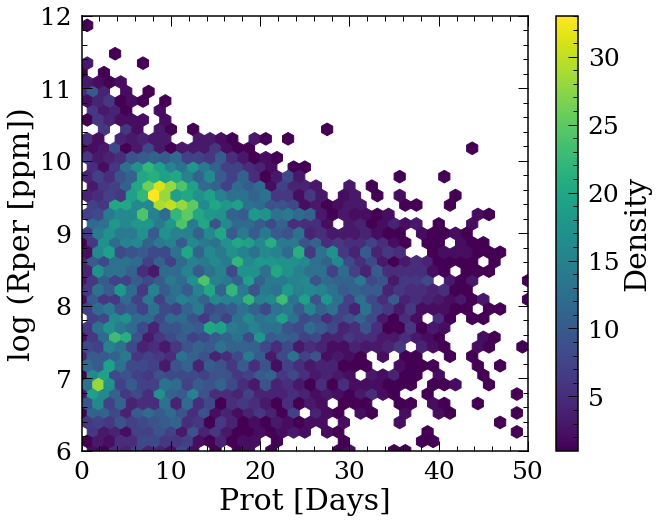

In [129]:
plt.figure(figsize=(10,8))
plt.hexbin(prot['Prot_x'], np.log(prot['Rper']), gridsize=40, extent=(0,50,6,12),mincnt=1)
plt.xlabel('Prot [Days]')
plt.ylabel('log (Rper [ppm])')
plt.xlim([0,50])
plt.ylim([6,12])
cb = plt.colorbar()
cb.set_label('Density')

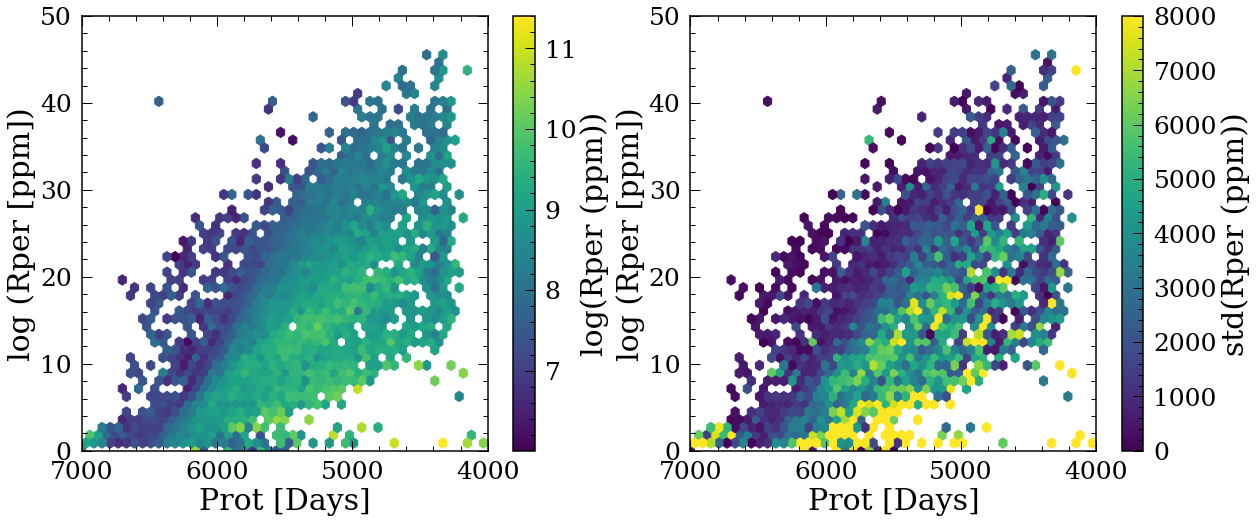

In [130]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,2)
plt.hexbin(prot['Teff_lam'], prot['Prot_x'], C=prot['Rper'], gridsize=50, extent=(4000,7000, 0,50),mincnt=1,
          reduce_C_function=np.std, vmin=0, vmax=8000)
plt.xlabel('Prot [Days]')
plt.ylabel('log (Rper [ppm])')
plt.xlim([7000,4000])
plt.ylim([0,50])
cb = plt.colorbar()
cb.set_label('std(Rper (ppm))')

plt.subplot(1,2,1)
plt.hexbin(prot['Teff_lam'], prot['Prot_x'], C=np.log(prot['Rper']), gridsize=50, extent=(4000,7000, 0,50),mincnt=1)
plt.xlabel('Prot [Days]')
plt.ylabel('log (Rper [ppm])')
plt.xlim([7000,4000])
plt.ylim([0,50])
cb = plt.colorbar()
cb.set_label('log(Rper (ppm))')
